<a href="https://colab.research.google.com/github/magiclenged/gitskills/blob/main/1st_order_ODE_PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Main Libraries

In [ ]:
# Tensorflow Keras and rest of the packages
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

## Definition of the PINN

In [ ]:
class ODE_1st(tf.keras.Model):
    def train_step(self, data):
        # Training points and the analytical (exact) solution at this points
        x, y_exact = data
        # Initial conditions for the PINN
        x0=tf.constant([0.0], dtype=tf.float32)
        y0_exact=tf.constant([1.0], dtype=tf.float32)
        # Calculate the gradients and update weights and bias
        with tf.GradientTape() as tape:
            # Calculate the gradients dy/dx
            with tf.GradientTape() as tape2:
              tape2.watch(x0)
              tape2.watch(x)
              y0_NN = self(x0, training=True)
              y_NN  = self(x, training=True)
            dy_dx_NN= tape2.gradient(y_NN,x)
            #Loss= ODE+ boundary/initial conditions
            loss=self.compiled_loss(dy_dx_NN, -y_NN)\
                +self.compiled_loss(y0_NN,y0_exact)
        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        self.compiled_metrics.update_state(y_exact, y_NN)
        return {m.name: m.result() for m in self.metrics}

## Run the PINN

In [ ]:
n_train = 20
xmin = 0
xmax = 4

# Definition of the function domain
x_train=np.linspace(xmin,xmax,n_train)

# The real solution y(x) for training evaluation
y_train=tf.exp(-x_train)

# Input and output neurons (from the data)
input_neurons  = 1
output_neurons = 1

# Hiperparameters
epochs = 40

# Definition of the the model
activation='elu'
input=Input(shape=(input_neurons,))
x=Dense(50, activation=activation)(input)
x=Dense(50, activation=activation)(x)
x=Dense(50, activation=activation)(x)
output = Dense(output_neurons,activation=None)(x)
model=ODE_1st(input,output)

# Definition of the metrics, optimizer and loss
loss= tf.keras.losses.MeanSquaredError()
metrics=tf.keras.metrics.MeanSquaredError()
optimizer= Adam(learning_rate=0.001)

model.compile(loss=loss,
          optimizer=optimizer,
          metrics=[metrics])
model.summary()

history=model.fit(x_train, y_train,batch_size=1,epochs=epochs)

Model: "ode_1st"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 50)                100       
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 5251 (20.51 KB)
Trainable params: 5251 (20.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/40
20/20 [=======

## Evolution of losses during training

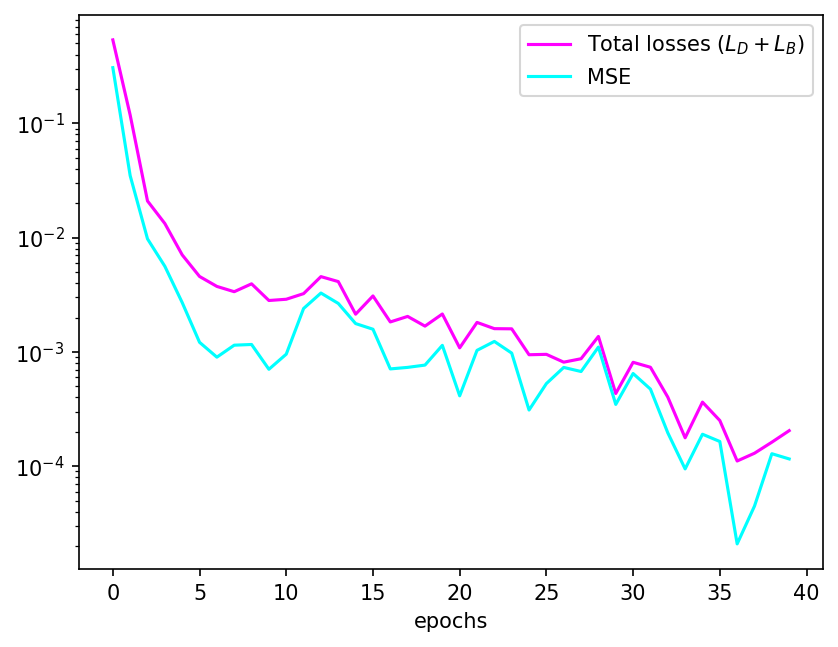

In [ ]:
import matplotlib.pyplot as plt
# summarize history for loss and metris
plt.rcParams['figure.dpi'] = 150
plt.plot(history.history['loss'],color='magenta',
         label='Total losses ($L_D + L_B$)')
plt.plot(history.history['mean_squared_error'],color='cyan',label='MSE')
plt.yscale("log")
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show()

## Solution and its derivatives

16/16 [==============================] - 0s 3ms/step


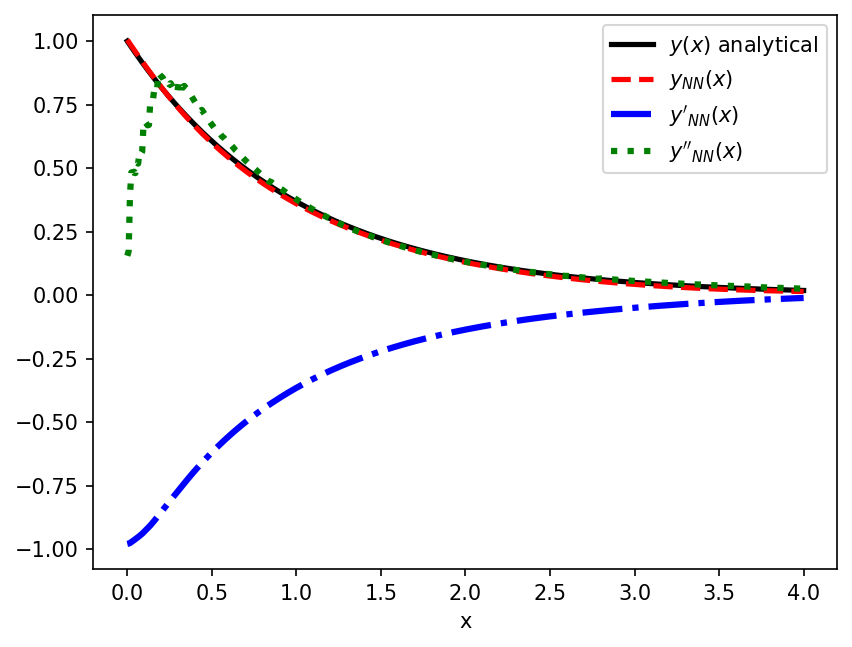

In [ ]:
# Check the PINN at different points not included in the training set
n = 500
x=np.linspace(0,4,n)
y_exact=tf.exp(-x)
y_NN=model.predict(x)

# The gradients (y'(x) and y''(x)) from the model
x_tf = tf.convert_to_tensor(x, dtype=tf.float32)
with tf.GradientTape(persistent=True) as t:
  t.watch(x_tf)
  with tf.GradientTape(persistent=True) as t2:
        t2.watch(x_tf)
        y = model(x_tf)
  dy_dx_NN = t2.gradient(y, x_tf)
d2y_dx2_NN = t.gradient(dy_dx_NN, x_tf)

# Plot the results
plt.rcParams['figure.dpi'] = 150
plt.plot(x, y_exact, color="black",linestyle='solid',
                     linewidth=2.5,label="$y(x)$ analytical")
plt.plot(x, y_NN, color="red",linestyle='dashed',
                     linewidth=2.5, label="$y_{NN}(x)$")
plt.plot(x, dy_dx_NN, color="blue",linestyle='-.',
                     linewidth=3.0, label="$y'_{NN}(x)$")
plt.plot(x, d2y_dx2_NN, color="green", linestyle='dotted',
                     linewidth=3.0, label="$y''_{NN}(x)$")
plt.legend()
plt.xlabel("x")
plt.show()